# Reverter

In this notebook we calculate back from an immission signal to the source.

In [12]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from auraliser import Reverter
from acoustics._signal import Signal
from IPython.display import Audio
import seaborn as sns

We start by loading the signal

In [13]:
filename = '../data/recording.wav'
signal = Signal.from_wav(filename)

In [14]:
from scipy.signal import decimate
ratio = 2
signal = Signal(decimate(signal, ratio), fs=int(signal.fs/ratio))

Let's have a look at its spectrogram.

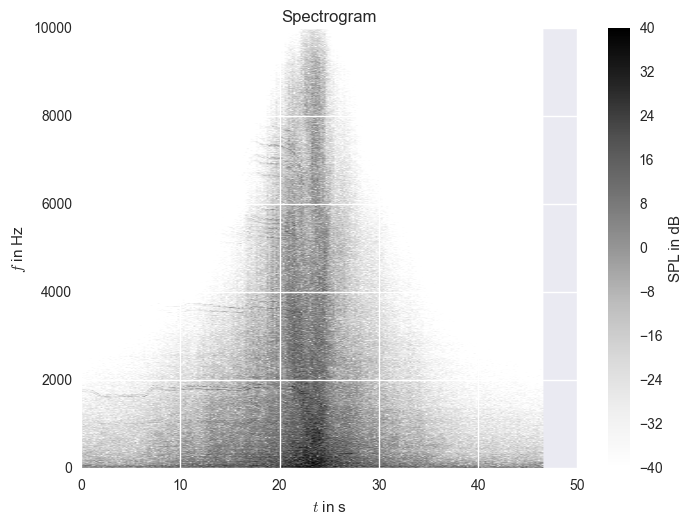

In [15]:
fig = signal.spectrogram(ylim=(0.0,10000), clim=(-40,40))

In [16]:
Audio(data=signal, rate=signal.fs)

In [17]:
velocity = 65.0  # Velocity of the source in m/s. Guess
xyz_strip = np.array([1600.0, 0.0, -20.0])  # Touchdown coordinate
xyz_receiver = np.array([0.0, 0.0, 0.0])    # Receiver
xyz_passage = np.array([0.0, 0.0, 80.0])    # Height of source at passage
t_passage = 23.8   # Time after start of recording that the aircraft passes the receiver location

In [18]:
# Let's create a model. We ultimately need position vectors for the source and receiver.
fs = signal.fs

duration = fs * len(signal)
distance_per_sample = velocity / fs    # Velocity vector expressed in meters per sample
distance = xyz_strip - xyz_passage          # Distance between passage and touchdown 
orientation = distance / np.linalg.norm(distance)   # This results in the bearing of the aircraft.

print(np.degrees(np.arctan(orientation[2]/orientation[0])))

assert(orientation[2] < 0.0)                # The aircraft should decrease in altitude...

dxds = distance_per_sample * orientation    # Let's create a velocity vector instead!!
source = np.outer( dxds, np.arange(0, len(signal)))   # Position of source, not yet given the right offset.
s_passage = t_passage * fs
source = source.transpose()
source = source - source[s_passage,:] + xyz_passage.transpose()
receiver = np.ones((len(signal), 3)) * xyz_receiver

assert source[-1,2] > xyz_strip[2]  # That we have no crash...

-3.576334375


In [19]:
reverter = Reverter(source, receiver)

In [20]:
reverted = reverter.revert(signal)

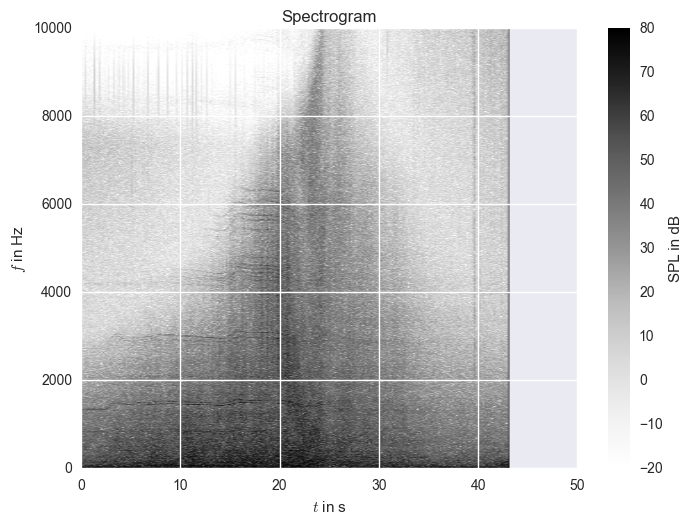

In [21]:
fig = reverted.spectrogram(ylim=(0.0,10000), clim=(-20,80))

In [22]:
Audio(data=reverted, rate=reverted.fs)